In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from openbb import obb

## EQUITIES

In [2]:
# Define the symbols
symbols = ['^GSPC', '^IXIC', '^GDAXI', '^FTSE', '^FCHI', '^N225', 'MME=F']  # MME=F is a ICE futures expiring 15/03/2024

# Download the data
data = yf.download(symbols, start='2023-12-28', end='2024-01-31')

# Adjust closing prices and rename columns
df = data["Adj Close"].dropna()
df.columns = ["EM", "CAC 40", "FTSE 100", "DAX", "SP500", "NASDAQ", "Nikkei 225"]

# Calculate daily percentage change and drop the first NaN
rets = df.pct_change().dropna()

# Adding 1 to the percentage changes for cumulative product calculation
rets += 1

# Set the first row of returns to 1, so when we calculate the cumulative product it starts from 100
rets.iloc[0] = 1

# Calculate the trajectory by cumulative product and then multiply by 100 to scale from a base of 100
trajectory = rets.cumprod() * 100


[*********************100%%**********************]  7 of 7 completed


In [3]:
performance = pd.DataFrame(((df.iloc[-1]/df.iloc[1])-1)*100)
performance.columns = ["Jan(%)"]
performance["YTD(%)"] = pd.DataFrame(((df.iloc[-1]/df.iloc[1])-1)*100)

performance

,Jan(%),YTD(%)
EM,-4.546768,-4.546768
CAC 40,1.780284,1.780284
FTSE 100,-0.865106,-0.865106
DAX,1.317478,1.317478
SP500,3.252530,3.252530
NASDAQ,3.321159,3.321159
Nikkei 225,7.774546,7.774546


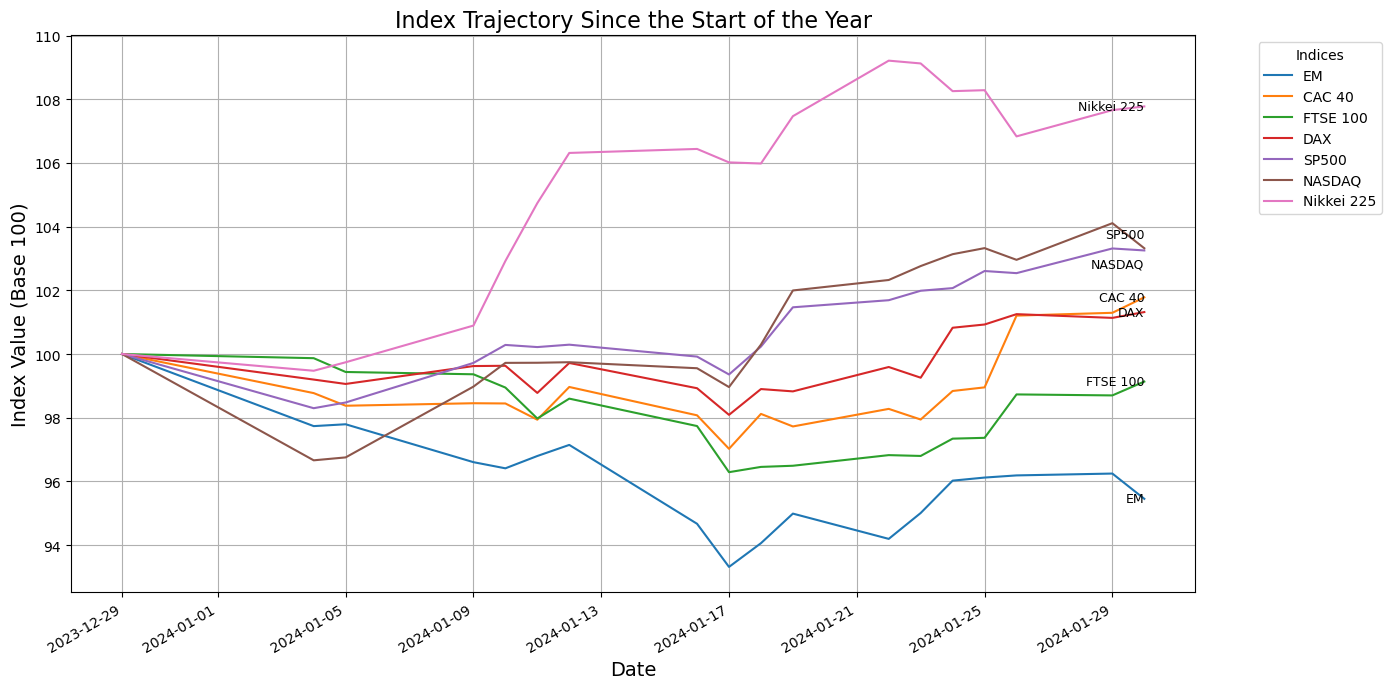

In [4]:
# Plot the data
plt.figure(figsize=(14, 7))  # Set the figure size


for column in trajectory.columns:
    plt.plot(trajectory.index, trajectory[column], label=column)
    # Determine the last date and value for the column
    last_date = trajectory.index[-1]  # Last date in the index
    last_value = trajectory[column].iloc[-1]  # Last value for the column
    
    # Check if the column is NASDAQ or SPX and adjust the vertical position slightly
    if column == "NASDAQ":
        offset = -0.5  # Adjust vertical position down for NASDAQ
    elif column == "SP500":
        offset = 0.5  # Adjust vertical position up for SPX
    else:
        offset = 0  # No offset for other indices
    
    # Annotate the last point on each line with an offset if applicable
    plt.text(last_date, last_value + offset, f'{column}', fontsize=9, va='center', ha='right')

# Set the title and labels
plt.title('Index Trajectory Since the Start of the Year', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Index Value (Base 100)', fontsize=14)

# Improve formatting of the x-axis for dates
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()  # Rotation

# Add a legend
plt.legend(title='Indices', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show grid
plt.grid(True)

# Adjust layout and show plot
plt.tight_layout()
plt.show()

## FIXED INCOME

In [5]:

# Fetching and cleaning Treasury rates
rates = obb.fixedincome.government.treasury_rates(start_date="2023-12-29", end_date="2024-01-30").to_df().dropna()

# Selecting specific dates and transposing for comparison
us_rates = rates.loc[['2023-12-29', '2024-01-30']].T

# EU rates data for comparison
eu_data = {
    
    'Dec_23': [3.652, 3.595, 3.606, 3.194, 2.402, 2.324, 1.949, 1.941, 2.031, 2.314, 2.279],
    'Jan_24': [3.859, 3.736, 3.603, 3.157, 2.422, 2.209, 2.057, 2.042, 2.168, 2.449, 2.401]
}
eu_rates = pd.DataFrame(eu_data, index=us_rates.index)
eu_rates['MΔ'] = eu_rates['Jan_24'] - eu_rates['Dec_23']

# Matching US rates format for comparison
us_rates['Change'] = us_rates['2024-01-30'] - us_rates['2023-12-29']
us_rates.columns = ['Dec_23', 'Jan_24', 'MΔ']


In [6]:
eu_rates

,Dec_23,Jan_24,MΔ
month_1,3.652,3.859,0.207
month_3,3.595,3.736,0.141
month_6,3.606,3.603,-0.003
year_1,3.194,3.157,-0.037
year_2,2.402,2.422,0.020
year_3,2.324,2.209,-0.115
year_5,1.949,2.057,0.108
year_7,1.941,2.042,0.101
year_10,2.031,2.168,0.137
year_20,2.314,2.449,0.135


In [7]:
us_rates

,Dec_23,Jan_24,MΔ
month_1,5.60,5.53,-0.07
month_3,5.40,5.42,0.02
month_6,5.26,5.19,-0.07
year_1,4.79,4.80,0.01
year_2,4.23,4.36,0.13
year_3,4.01,4.14,0.13
year_5,3.84,4.00,0.16
year_7,3.88,4.03,0.15
year_10,3.88,4.06,0.18
year_20,4.20,4.40,0.20


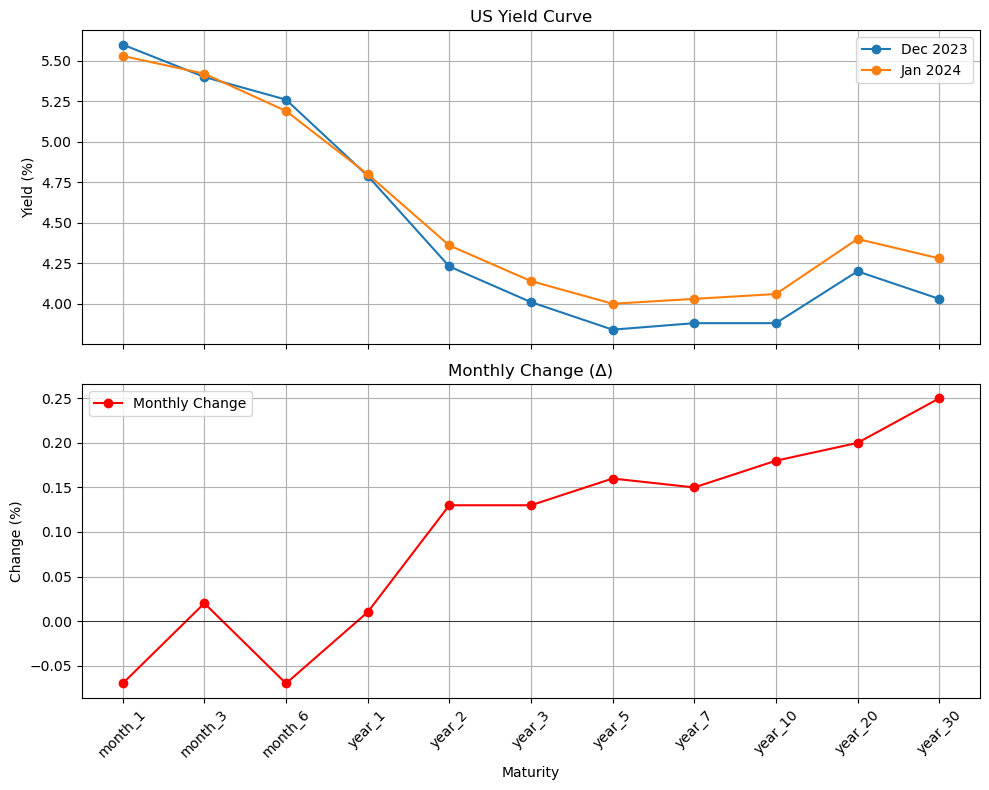

In [8]:

# Create a figure and a set of subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Plot Dec_23 and Jan_24 on the first subplot
ax1.plot(us_rates.index, us_rates['Dec_23'], marker='o', label='Dec 2023')
ax1.plot(us_rates.index, us_rates['Jan_24'], marker='o', label='Jan 2024')
ax1.set_title('US Yield Curve')
ax1.set_ylabel('Yield (%)')
ax1.legend()
ax1.grid(True)

# Plot MΔ on the second subplot
ax2.plot(us_rates.index, us_rates['MΔ'], marker='o', color='red', label='Monthly Change')
ax2.axhline(0, color='black', linewidth=0.5)  # Add a horizontal line at 0 for reference
ax2.set_title('Monthly Change (Δ)')
ax2.set_ylabel('Change (%)')
ax2.set_xlabel('Maturity')
ax2.legend()
ax2.grid(True)

plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout
plt.show()


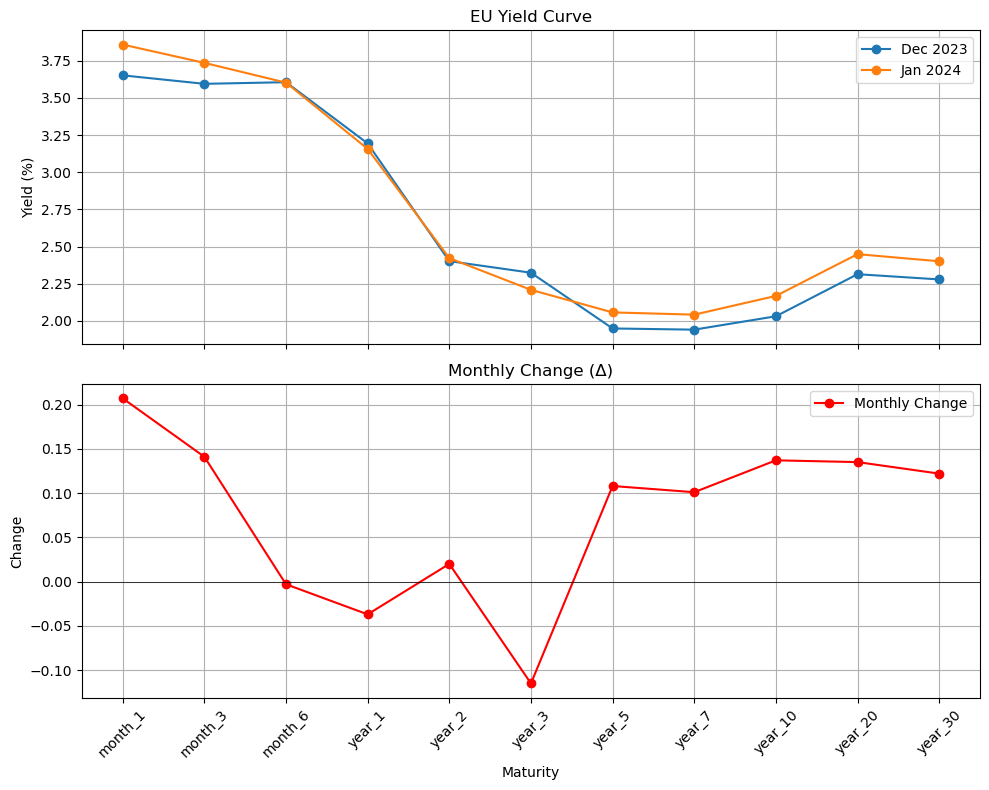

In [9]:

# Create a figure and a set of subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Plot Dec_23 and Jan_24 on the first subplot
ax1.plot(eu_rates.index, eu_rates['Dec_23'], marker='o', label='Dec 2023')
ax1.plot(eu_rates.index, eu_rates['Jan_24'], marker='o', label='Jan 2024')
ax1.set_title('EU Yield Curve')
ax1.set_ylabel('Yield (%)')
ax1.legend()
ax1.grid(True)

# Plot MΔ on the second subplot
ax2.plot(eu_rates.index, eu_rates['MΔ'], marker='o', color='red', label='Monthly Change')
ax2.axhline(0, color='black', linewidth=0.5)  # Add a horizontal line at 0 for reference
ax2.set_title('Monthly Change (Δ)')
ax2.set_ylabel('Change')
ax2.set_xlabel('Maturity')
ax2.legend()
ax2.grid(True)

plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout
plt.show()


## SPREAD

In [10]:
# Calculating spread between US and EU
spread = (us_rates-eu_rates)*100

# Naming columns
spread.columns = ["Dec_23(bps)", "Jan_24(bps)", "MΔ(bps)"]

spread

,Dec_23(bps),Jan_24(bps),MΔ(bps)
month_1,194.8,167.1,-27.7
month_3,180.5,168.4,-12.1
month_6,165.4,158.7,-6.7
year_1,159.6,164.3,4.7
year_2,182.8,193.8,11.0
year_3,168.6,193.1,24.5
year_5,189.1,194.3,5.2
year_7,193.9,198.8,4.9
year_10,184.9,189.2,4.3
year_20,188.6,195.1,6.5


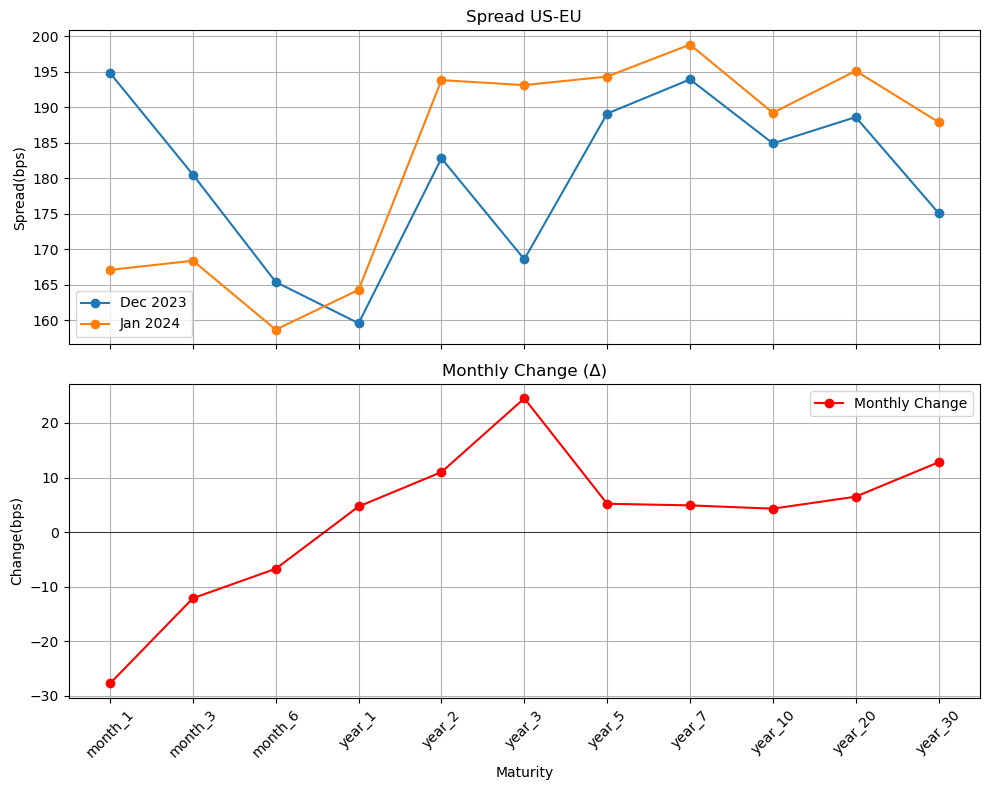

In [11]:

# Create a figure and a set of subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Plot Dec_23 and Jan_24 on the first subplot
ax1.plot(spread.index, spread['Dec_23(bps)'], marker='o', label='Dec 2023')
ax1.plot(spread.index, spread['Jan_24(bps)'], marker='o', label='Jan 2024')
ax1.set_title('Spread US-EU')
ax1.set_ylabel('Spread(bps)')
ax1.legend()
ax1.grid(True)

# Plot MΔ on the second subplot
ax2.plot(spread.index, spread['MΔ(bps)'], marker='o', color='red', label='Monthly Change')
ax2.axhline(0, color='black', linewidth=0.5)  # Add a horizontal line at 0 for reference
ax2.set_title('Monthly Change (Δ)')
ax2.set_ylabel('Change(bps)')
ax2.set_xlabel('Maturity')
ax2.legend()
ax2.grid(True)

plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout
plt.show()


## FX

In [12]:
# Define the symbols for FX
symbols_fx = ['EURCHF=X', 'EURUSD=X', 'EURJPY=X']  

# Download the data
data_fx = yf.download(symbols_fx, start='2023-12-28', end='2024-01-31')

# Adjust closing prices and rename columns
fx = data_fx["Adj Close"].dropna()
fx.columns = ["EURCHF", "EURJPY", "EURUSD"]

# Calculate daily percentage change and drop the first NaN
rets_fx = fx.pct_change().dropna()

# Adding 1 to the percentage changes for cumulative product calculation
rets_fx += 1

# Set the first row of returns to 1, so when we calculate the cumulative product it starts from 100
rets_fx.iloc[0] = 1

# Calculate the trajectory by cumulative product and then multiply by 100 to scale from a base of 100
trajectory_fx = rets_fx.cumprod() * 100


[*********************100%%**********************]  3 of 3 completed


In [13]:
performance_fx = pd.DataFrame(((fx.iloc[-1]/fx.iloc[1])-1)*100)
performance_fx.columns = ["Jan(%)"]
performance_fx["YTD(%)"] = pd.DataFrame(((fx.iloc[-1]/fx.iloc[1])-1)*100)

performance_fx.round(2)

,Jan(%),YTD(%)
EURCHF,-0.03,-0.03
EURJPY,2.06,2.06
EURUSD,-2.11,-2.11


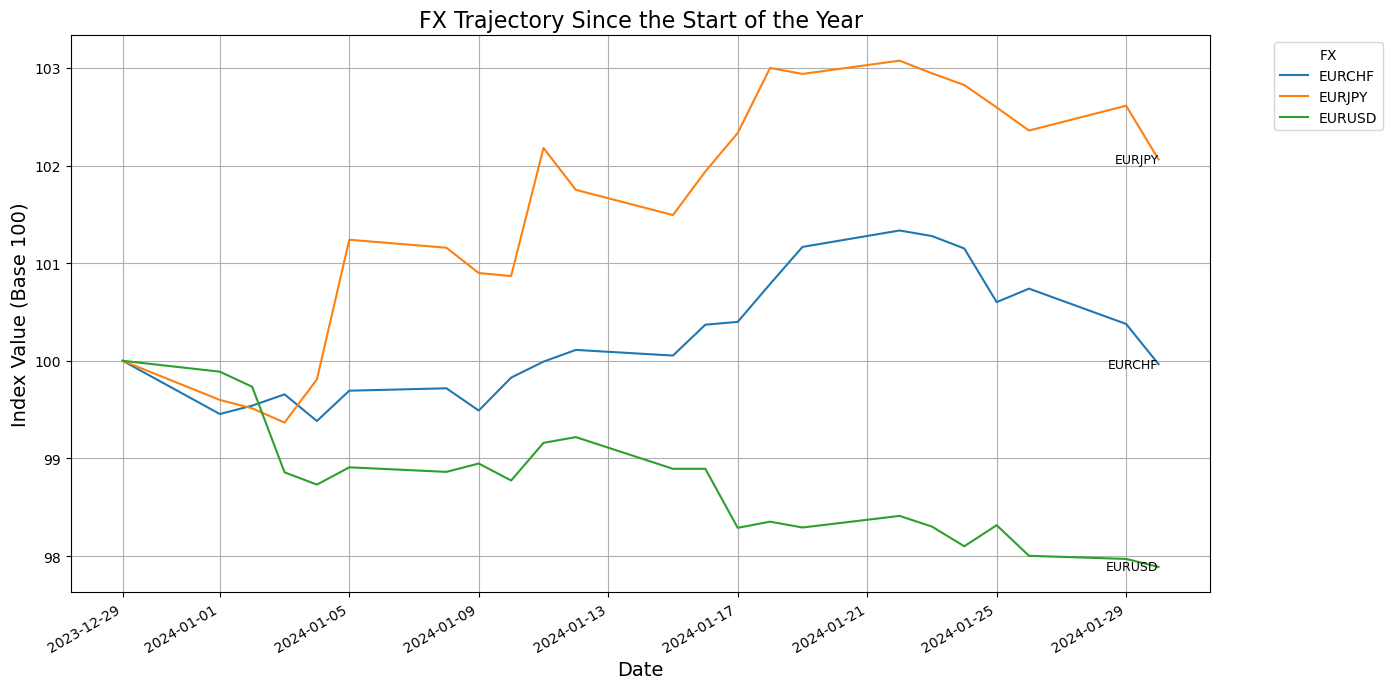

In [14]:
# Plot the data
plt.figure(figsize=(14, 7))  # Set the figure size


for column in trajectory_fx.columns:
    plt.plot(trajectory_fx.index, trajectory_fx[column], label=column)
    # Determine the last date and value for the column
    last_date = trajectory_fx.index[-1]  # Last date in the index
    last_value = trajectory_fx[column].iloc[-1]  # Last value for the column
    
    # Annotate the last point on each line with an offset if applicable
    plt.text(last_date, last_value + offset, f'{column}', fontsize=9, va='center', ha='right')

# Set the title and labels
plt.title('FX Trajectory Since the Start of the Year', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Index Value (Base 100)', fontsize=14)

# Improve formatting of the x-axis for dates
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()  # Rotation

# Add a legend
plt.legend(title='FX', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show grid
plt.grid(True)

# Adjust layout and show plot
plt.tight_layout()
plt.show()
